- check the val/test dataframes (linear-esque cost functions)
- convert to pipeline format

baseline, pp only: 18.238665283473274, 4.983758107647128

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('max.columns', 500)
pd.set_option('max.rows', 500)

In [39]:
df = pd.read_csv('../data/nascar_fd.csv', parse_dates=['date'])
df = df.sort_values(by='date')

In [40]:
val_split = int(len(df.date.unique()) * 0.6)
test_split = int(len(df.date.unique()) * 0.8)

train = df[df.date < df.date.unique()[val_split]]
val = df[df.date < df.date.unique()[test_split]]
test = df.copy()

[len(x.date.unique()) for x in (train, val, test)]

[53, 71, 89]

### Data Processing

In [23]:
from sklearn.cluster import KMeans

In [24]:
def add_cluster(df):
    cluster = df[['laps_2', 'miles_2', 'cautions_race_2']]
    cluster = cluster.groupby(['laps_2', 'miles_2']).cautions_race_2.mean().reset_index()
    cluster['cautions_race_2'].fillna(cluster['cautions_race_2'].median(), inplace=True)
    
    cluster.drop_duplicates(inplace=True)
    
    kmeans = KMeans(n_clusters=3, random_state=4)
    kmeans.fit(cluster)    
    
    cluster['cluster'] = kmeans.predict(cluster)
    
    return df.merge(cluster[['laps_2', 'miles_2', 'cluster']], how='left', on=['laps_2', 'miles_2'])

In [25]:
def preprocessing(df):
    df['qualifying_pos_na'] = np.where(df['qualifying_pos_1'].isnull(), 1, 0)
    df['qualifying_pos_1'] = df.groupby('name')['qualifying_pos_1'].apply(lambda x: x.fillna(x.median()))
    df['rank'] = df.groupby('date')['ps'].rank(ascending=False)    
    
    #for i in [1, 8, 15]:
    for i in [5]:
        col = f'rolling_{i}'
        df[col] = df.groupby('name', sort=False)['rank'].apply(lambda x: x.rolling(i).mean().shift())
        df[col].fillna(df[col].median(), inplace=True)
        
    #for i in [1, 3, 5, 10, 15, 20]:
    for i in [5]:
        col = f'rolling_track_{i}'
        df[col] = df.groupby(['name', 'cluster'], sort=False)['rank'].apply(lambda x: x.rolling(i).mean().shift())
        df[col].fillna(df[col].median(), inplace=True)
        
    df['career_average'] = df.groupby('name')['rank'].transform('mean')
    df['career_std'] = df.groupby('name')['rank'].transform('std')
    df['career_std'] = df['career_std'].fillna(df['career_std'].median())
    
    df['cautions_race_2'] = df['cautions_race_2'].fillna(df['cautions_race_2'].median())
    
    df['surface_2'] = pd.factorize(df['surface_2'])[0]
    df['restrictor_plate_2'] = pd.factorize(df['restrictor_plate_2'])[0]  
    
    df['day'] = df.date.dt.day
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    
    df = pd.get_dummies(df, columns=['player_id'])
    
    return df

In [26]:
train = add_cluster(train)

In [27]:
train = preprocessing(train)

In [28]:
train.tail()

,primary_id,event_id,s,name,pos,sal,gid,gi,date,ppg,pp,ps,ss,stat,is_,notes,floor,ceil,conf,ptid,otid,htid,oe,opprank,opptotal,dspid,dgid,img,pteam,hteam,oteam,lock,id,salaryid,owned,hatecount,lovecount,races_0,wins_0,top_fives_0,top_tens_0,avg_finish_0,laps_led_race_0,fastest_laps_race_0,avg_pass_diff_0,quality_passes_race_0,fppg_0,practice_laps_1,practice_best_lap_time_1,practice_best_lap_speed_1,qualifying_pos_1,qualifying_best_lap_time_1,qualifying_best_lap_speed_1,laps_2,miles_2,surface_2,restrictor_plate_2,cautions_race_2,races_3,finished_3,wins_3,top_5s_3,top_10s_3,avg_place_3,races_4,finished_4,wins_4,top_5s_4,top_10s_4,avg_place_4,projections,cluster,qualifying_pos_na,rank,rolling_5,rolling_track_5,career_average,career_std,day,month,year,player_id_1,player_id_6,player_id_8,player_id_9,player_id_14,player_id_15,player_id_16,player_id_17,player_id_18,player_id_19,player_id_24,player_id_25,player_id_26,player_id_28,player_id_29,player_id_31,player_id_34,player_id_35,player_id_37,player_id_41,player_id_42,player_id_44,player_id_45,player_id_49,player_id_53,player_id_57,player_id_59,player_id_64,player_id_73,player_id_77,player_id_81,player_id_82,player_id_85,player_id_86,player_id_91,player_id_93,player_id_95,player_id_99,player_id_101,player_id_102,player_id_104,player_id_107,player_id_109,player_id_110,player_id_114,player_id_121,player_id_126,player_id_139,player_id_140,player_id_141,player_id_144,player_id_145,player_id_152,player_id_154,player_id_155,player_id_157,player_id_159,player_id_160,player_id_161,player_id_162,player_id_163,player_id_164,player_id_165,player_id_166,player_id_167,player_id_168,player_id_169,player_id_170,player_id_172
1909,1890,261,2,Alex Bowman,D,10000,268,NaN,2019-08-11,52.89,40.14,48.0,4,1,0,"[{""Alert"":3,""Note"":""1 wins, 6 Top 5's, 9 Top 1...",10.6,90.0,0.0,0,-1,0,NaN,0,0,82859,0,NaN,NaN,NaN,NaN,0,8289,NaN,NaN,0.0,1.0,25,1,6,9,12.8,8.2,7.0,3.7,50.0,37.6,73,38.104,188.957,4.0,37.993,189.509,200,400.0,0,1,7.2,8,7,0,0,1,26.6,117,96,1,8,19,23.9,False,2,0,15.0,16.8,13.2,17.166667,10.204247,11,8,2019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1910,1891,261,2,Aric Almirola,D,9700,268,NaN,2019-08-11,51.05,40.40,16.8,4,1,0,"[{""Alert"":3,""Note"":""1 Top 5's, 12 Top 10's thi...",0.0,78.5,0.0,0,-1,0,NaN,0,0,82855,0,NaN,NaN,NaN,NaN,0,8290,NaN,NaN,2.0,0.0,24,0,1,12,12.8,4.7,6.0,-1.2,61.1,33.7,67,38.215,188.408,12.0,38.219,188.388,200,400.0,0,1,7.2,12,12,0,0,1,18.3,188,167,2,12,48,17.8,False,2,0,34.0,14.2,17.0,14.384615,9.536111,11,8,2019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1911,1892,261,2,Clint Bowyer,D,9400,268,NaN,2019-08-11,47.34,48.91,1.9,4,1,0,"[{""Alert"":3,""Note"":""Top 10 in each practice ru...",1.5,102.0,0.0,0,-1,0,NaN,0,0,82860,0,NaN,NaN,NaN,NaN,0,8291,NaN,NaN,0.0,3.0,24,0,5,9,15.9,3.6,7.9,-3.8,46.1,27.5,64,37.930,189.823,5.0,38.007,189.439,200,400.0,0,1,7.2,13,12,1,2,6,18.4,196,168,3,25,61,17.4,False,2,0,36.0,19.9,19.0,16.622642,12.562500,11,8,2019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1912,1893,261,2,Daniel Suarez,D,9000,268,NaN,2019-08-11,50.02,41.04,59.0,4,1,0,"[{""Alert"":3,""Note"":""2 Top 5's, 8 Top 10's this...",0.0,89.0,0.0,0,-1,0,NaN,0,0,82901,0,NaN,NaN,NaN,NaN,0,8292,NaN,NaN,0.0,1.0,24,0,2,8,15.5,4.4,6.6,1.2,55.4,32.0,74,38.059,189.180,11.0,38.204,188.462,200,400.0,0,1,7.2,5,4,0,1,1,21.2,76,63,0,4,23,17.6,False,2,0,8.0,23.8,14.8,17.784314,10.027589,11,8,2019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1913,1887,261,2,Erik Jones,D,10600,268,NaN,2019-08-11,51.16,59.51,42.0,4,1,0,"[{""Alert"":3,""Note"":""8 Top 5's, 12 Top 10's thi...",0.0,90.5,0.0,0,-1,0,NaN,0,0,82883,0,NaN,NaN,NaN,NaN,0,8286,

In [29]:
nums = [
    'day', 'month', 'year',
    'sal',
    'ppg',
    'pp',
    'races_0', 'wins_0', 
    'top_fives_0', 'top_tens_0', 
    'avg_finish_0', 'laps_led_race_0',
    'fastest_laps_race_0', 'avg_pass_diff_0', 
    'quality_passes_race_0',
    'fppg_0', #'practice_laps_1', 'practice_best_lap_time_1',
    #'practice_best_lap_speed_1', 'qualifying_pos_1',
    #'qualifying_best_lap_time_1', 'qualifying_best_lap_speed_1', 
    'laps_2', 'miles_2', #'surface_2', 'restrictor_plate_2', 
    'cautions_race_2',
    'races_3', 'finished_3', 'wins_3', 
    'top_5s_3', 'top_10s_3',
    'avg_place_3', 'races_4', 'finished_4', 'wins_4',
    'top_5s_4',
    'top_10s_4', 'avg_place_4', 
    #'qualifying_pos_na',
    #'player_id',
    #'rolling_1', 'rolling_3', 'rolling_5',
    #   'rolling_10', 'rolling_15', 'rolling_20', 'rolling_track_1',
    #   'rolling_track_3', 'rolling_track_5', 'rolling_track_10',
    #   'rolling_track_15', 'rolling_track_20', 
    'career_average', 'career_std', 
    'cluster'
] + [x for x in train.columns if 'player_id_' in x]

response = 'ps'

In [46]:
gbm.

<bound method BaseEstimator.get_params of GradientBoostingRegressor(learning_rate=0.01, max_depth=4, max_features='sqrt',
                          n_estimators=300, random_state=4)>

### Inference

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
X = train[nums]
y = train[response]

In [32]:
gbm = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=300, max_features='sqrt', random_state=4)

gbm.fit(X, y)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, max_features='sqrt',
                          n_estimators=300, random_state=4)

In [33]:
mean_squared_error(train.ps, gbm.predict(train[nums]))**0.5

NameError: name 'mean_squared_error' is not defined

In [37]:
gbm.score(X, y)

0.44222450195194307

In [702]:
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance

In [894]:
pd.DataFrame({'cols': X.columns, 'fi': gbm.feature_importances_}).sort_values(by='fi')

,cols,fi
104,player_id_172,0.000000e+00
55,player_id_41,0.000000e+00
63,player_id_64,0.000000e+00
65,player_id_77,0.000000e+00
67,player_id_82,0.000000e+00
77,player_id_107,0.000000e+00
79,player_id_110,0.000000e+00
81,player_id_121,0.000000e+00
89,player_id_154,0.000000e+00
91,player_id_157,0.000000e+00


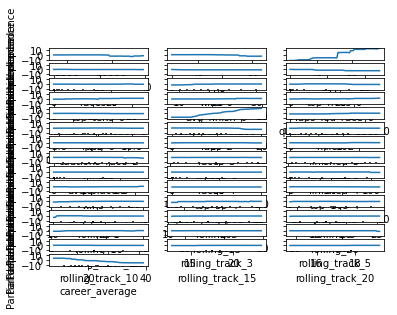

In [191]:
plot_partial_dependence(gbm, X, X.columns)

In [265]:
x = train[nums].corr('spearman')

for i in x.columns:
    print(i, x[x[i] != 1][i].max())

sal 0.8398042696335754
ppg 0.8675191804865134
pp 0.6006306343289486
races_0 0.663482922219096
wins_0 0.6953006625958906
top_fives_0 0.870730807272143
top_tens_0 0.870730807272143
avg_finish_0 0.8832907292626635
laps_led_race_0 0.8536642815577197
fastest_laps_race_0 0.8547485404190875
avg_pass_diff_0 0.5262863502846494
quality_passes_race_0 0.8006722379078325
fppg_0 0.8675191804865134
laps_2 0.6006306343289486
miles_2 0.7227155320595035
cautions_race_2 0.5539634536134895
races_3 0.9701174297215691
finished_3 0.9701174297215691
wins_3 0.6129284719047062
top_5s_3 0.8861804406812047
top_10s_3 0.8861804406812047
avg_place_3 0.5379928577430495
races_4 0.996706979393022
finished_4 0.996706979393022
wins_4 0.8820885743987387
top_5s_4 0.9686261746789833
top_10s_4 0.9686261746789833
avg_place_4 0.8537919181890227
player_id 0.5329147549947646
career_average 0.8832907292626635
cluster 0.7227155320595035
rolling_1 0.7586902222672268
rolling_2 0.8638133942504373
rolling_3 0.9073283434751651
rolling_

### Validation Check

In [483]:
from sklearn.metrics import mean_squared_error

In [484]:
batches = [x for x in val.date.unique() if x not in train.date.unique()]

In [864]:
def val_check(df, model, cols, response, batches):
    scores = []
    
    for batch in batches:
        tmp = df[df.date <= batch]
        tmp = add_cluster(tmp)
        tmp = preprocessing(tmp)
        
        preds = model.predict(tmp.loc[tmp.date==batch, cols])
        score = mean_squared_error(preds, tmp.loc[tmp.date==batch, response])**0.5
        scores.append(score)
        
    return scores

In [908]:
a = pd.Series(val_check(val, gbm, nums, response, batches))

In [909]:
#16.5743
a.mean(), a.std()

(16.63863765389077, 4.547998191239499)

In [853]:
#16.5743
a.mean(), a.std()

(16.57430528205043, 4.558310376235754)

<AxesSubplot:>

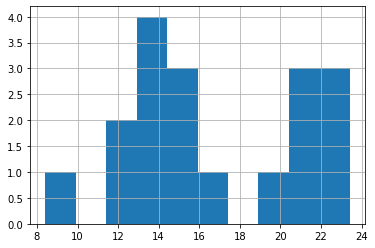

In [488]:
a.hist()